<a href="https://colab.research.google.com/github/kessingtonosazee/GCP_Project_1/blob/master/aml_2324_w4_shap_regr_intrct.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SHAP: Regression Examples, and Interactions

## Import Packages and Set Up Environment

In [ ]:
# latest version of scikit-learn: might need a kernel restart
!pip install --upgrade scikit-learn==1.4.0 -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 30.1 MB/s eta 0:00:00


In [ ]:
import sklearn
# this makes is easier for getting dataframes by default as input/output of
# sklearn pipelines
sklearn.set_config(transform_output="pandas")

%config InlineBackend.figure_format = 'retina'
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(
    { "figure.figsize": (6, 4) }, style='ticks', color_codes=True, font_scale=0.8
)
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.model_selection import GridSearchCV, ParameterGrid, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

In [ ]:
# SHAP is not normally part of a standard Python distribution
# I am installing it here by asking the underlying operating system to
# `pip install` the package (`-q` for a quiet output)
!pip install -q shap
import shap
shap.initjs()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 535.7/535.7 kB 4.6 MB/s eta 0:00:00


## Regression, Wine Quality Example

* Based on the book "Molnar, Christoph. Interpreting Machine Learning Models With SHAP. https://christophmolnar.com/books/shap/. 2020."

### Data Loading and Inspection

In [ ]:
url = 'https://raw.githubusercontent.com/gerberl/6G7V0017-2324/main/datasets/winequality-white.csv'

In [ ]:
wine = pd.read_csv(url, sep=';')

In [ ]:
wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [ ]:
wine.describe().T

,count,mean,std,min,25%,50%,75%,max
fixed acidity,4898.0,6.854788,0.843868,3.80000,6.300000,6.80000,7.3000,14.20000
volatile acidity,4898.0,0.278241,0.100795,0.08000,0.210000,0.26000,0.3200,1.10000
citric acid,4898.0,0.334192,0.121020,0.00000,0.270000,0.32000,0.3900,1.66000
residual sugar,4898.0,6.391415,5.072058,0.60000,1.700000,5.20000,9.9000,65.80000
chlorides,4898.0,0.045772,0.021848,0.00900,0.036000,0.04300,0.0500,0.34600
free sulfur dioxide,4898.0,35.308085,17.007137,2.00000,23.000000,34.00000,46.0000,289.00000
total sulfur dioxide,4898.0,138.360657,42.498065,9.00000,108.000000,134.00000,167.0000,440.00000
density,4898.0,0.994027,0.002991,0.98711,0.991723,0.99374,0.9961,1.03898
pH,4898.0,3.188267,0.151001,2.72000,3.090000,3.18000,3.2800,3.82000
sulphates,4898.0,0.489847,0.114126,0.22000,0.410000,0.47000,0.5500,1.08000


### Preparation for Training and Evaluation

In [ ]:
y = wine['quality']
X = wine.drop('quality', axis=1)
X_train, X_test, y_train, y_test = train_test_split(
  X, y, test_size=0.2, random_state=0
)

### A Sanity Check of SHAP with a Simple Linear Regression Model

#### Fitting and Scoring

In [ ]:
model = LinearRegression()
model = model.fit(X_train, y_train)

In [ ]:
eval_results = cross_validate(
    model, X, y, cv=5,
    scoring='neg_mean_absolute_error',
    return_train_score=True
)
print(-eval_results['test_score'].mean(), eval_results['test_score'].std())
print(-eval_results['train_score'].mean(), eval_results['train_score'].std())

0.5937976390149533 0.033266394463595354
0.5825614837883729 0.008222901541250644


#### Inspecting (with SHAP)

In [ ]:
coefs = pd.DataFrame({
  'feature': X.columns,
  'coefficient': np.round(model.coef_, 3)
})
coefs

,feature,coefficient
0,fixed acidity,0.107
1,volatile acidity,-1.810
2,citric acid,-0.015
3,residual sugar,0.093
4,chlorides,-0.557
5,free sulfur dioxide,0.004
6,total sulfur dioxide,-0.000
7,density,-188.993
8,pH,0.822
9,sulphates,0.639


In [ ]:
explainer = shap.LinearExplainer(model, X_train)

In [ ]:
shap_values = explainer(X_test)

In [ ]:
# these are the SHAP values themselves that we can always use as a dataset
shap_values.values

array([[ 4.52531818e-02, -1.17490103e-01,  1.06141200e-05, ...,
         5.16447498e-02, -4.98400966e-02,  2.35711841e-02],
       [ 1.31587266e-02, -9.93868511e-02,  1.37528669e-03, ...,
        -3.88157992e-02, -2.42810727e-02, -1.00487680e-01],
       [ 7.73476370e-02,  2.08368425e-01, -5.90296702e-03, ...,
        -8.81579168e-02, -6.26196085e-02,  3.73555023e-02],
       ...,
       [ 4.52531818e-02,  1.35955419e-01, -4.53829445e-03, ...,
         1.25657926e-01,  7.79550228e-02, -1.55624952e-01],
       [ 2.46057490e-03, -2.26109612e-01,  9.20395834e-04, ...,
        -1.45723721e-01,  6.51755109e-02, -1.41840634e-01],
       [-8.23757683e-03, -6.96794152e-01,  4.10463184e-03, ...,
         1.58552671e-01, -2.42810727e-02, -2.24546543e-01]])

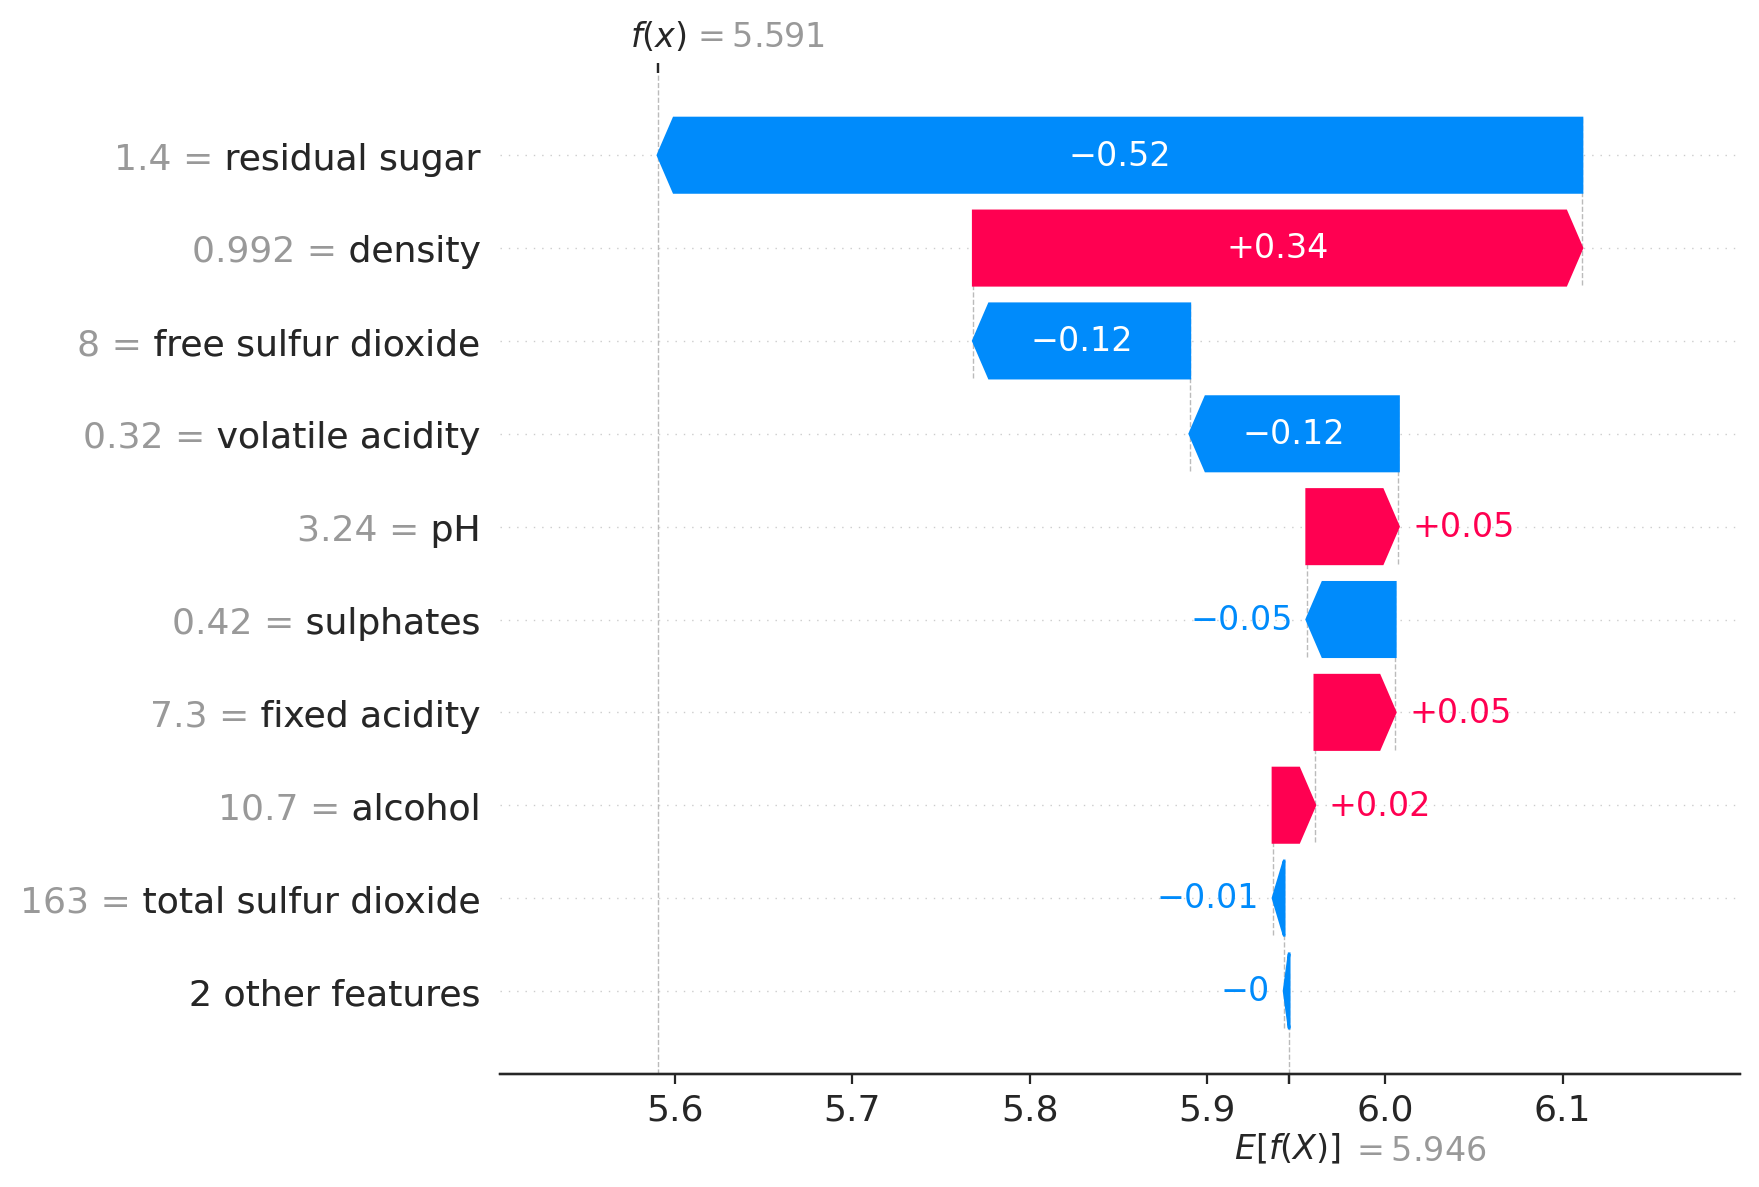

In [ ]:
# for a random instance
shap.plots.waterfall(shap_values[0])

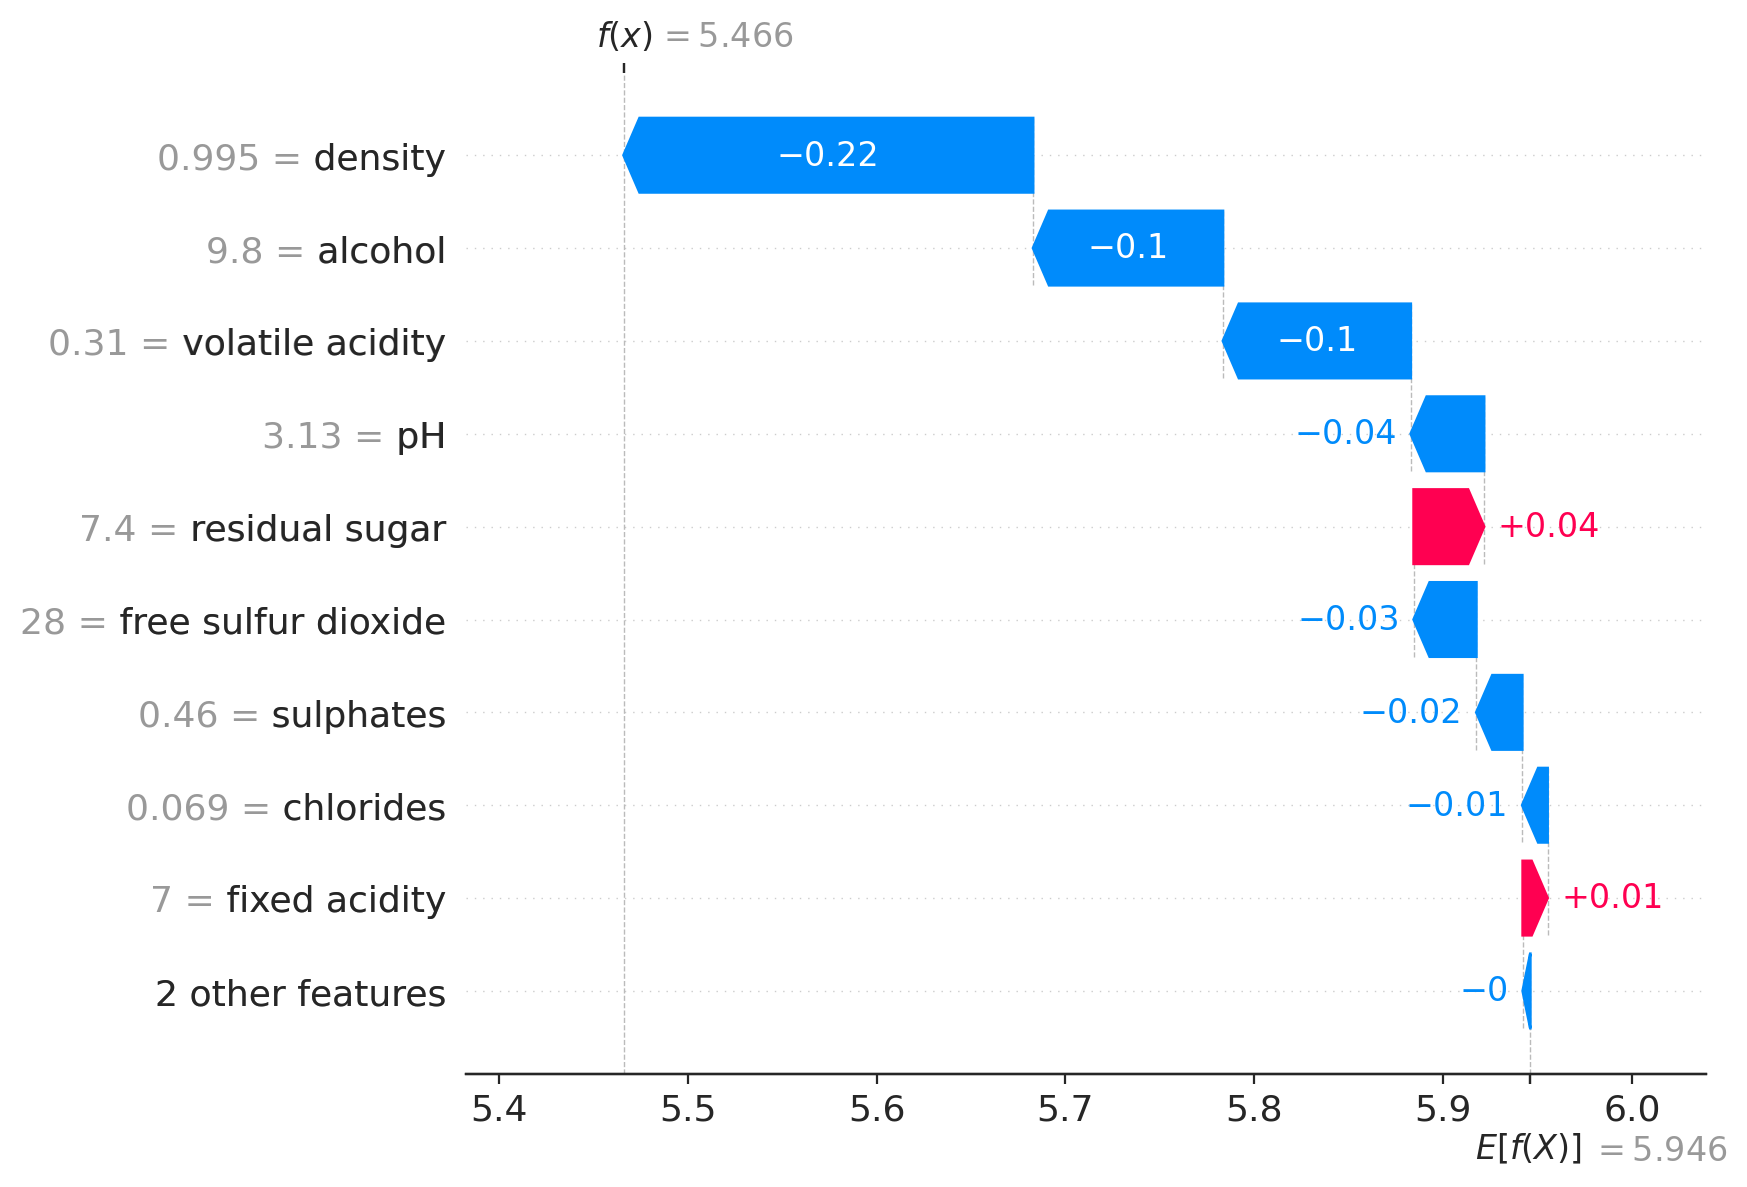

In [ ]:
# another wine
shap.waterfall_plot(shap_values[1])

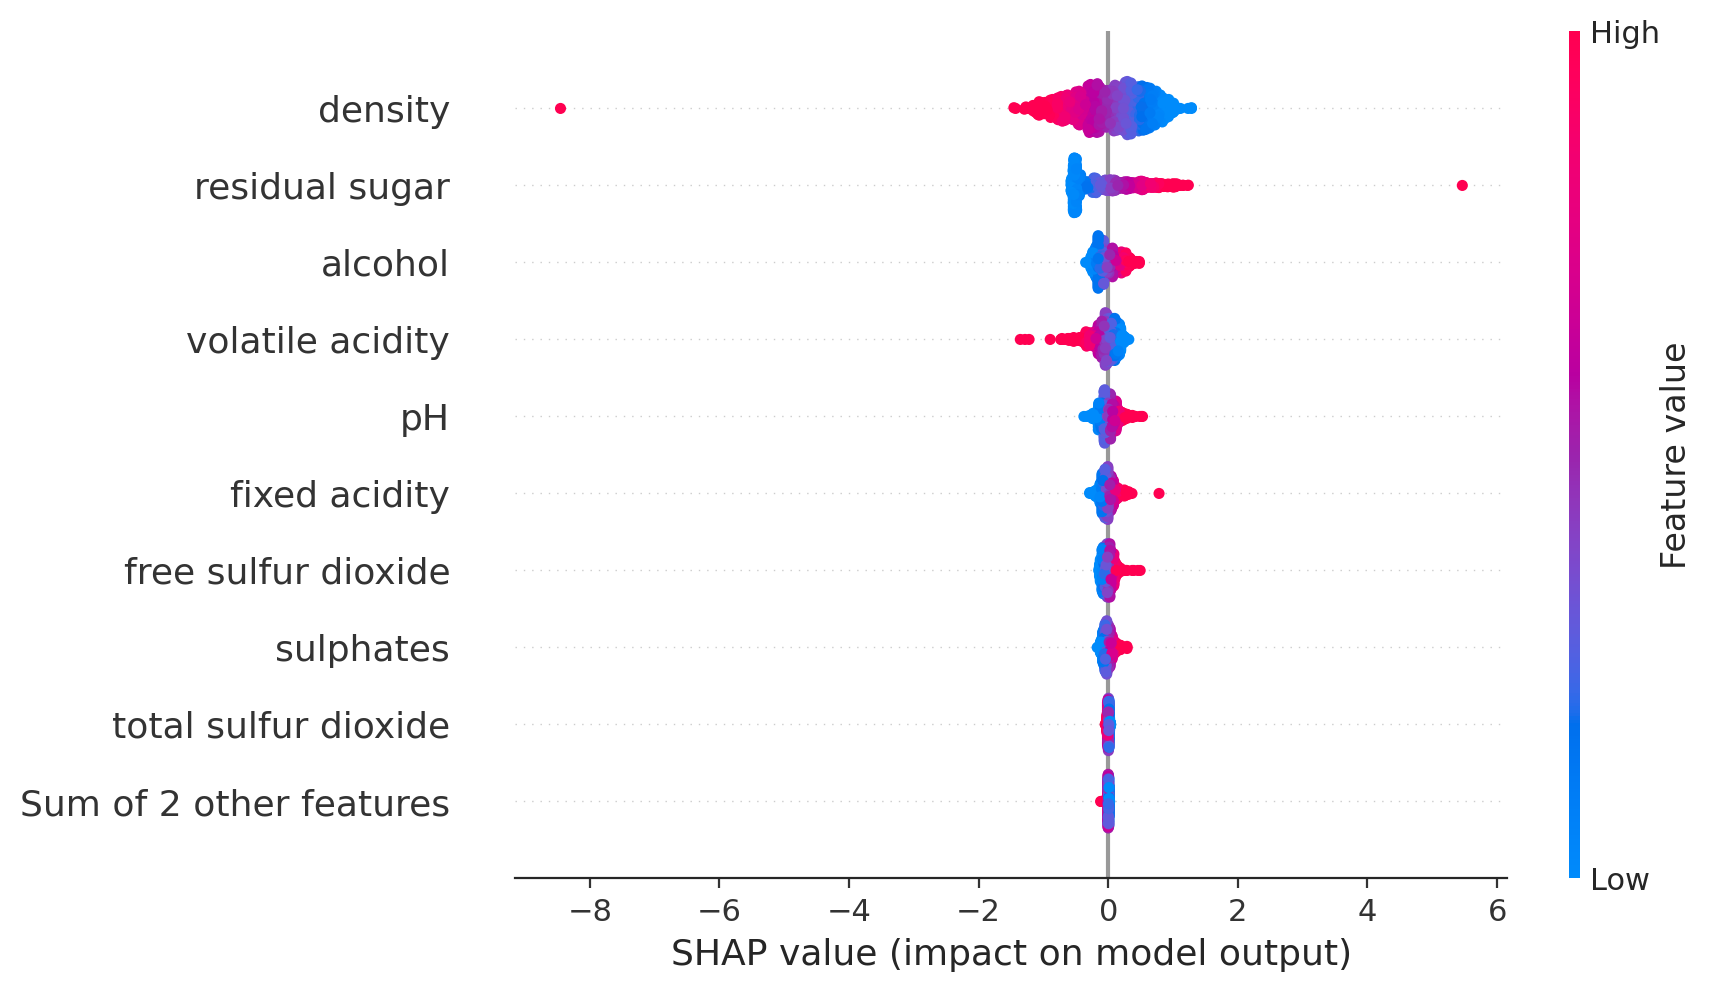

In [ ]:
# global model
shap.plots.beeswarm(shap_values)

In [ ]:
# what does the above tell you what the average effect of features in the predictions?
# how does it reflect the coefficients assigned to each feature by the model?

#### SHAP Scatter Plots

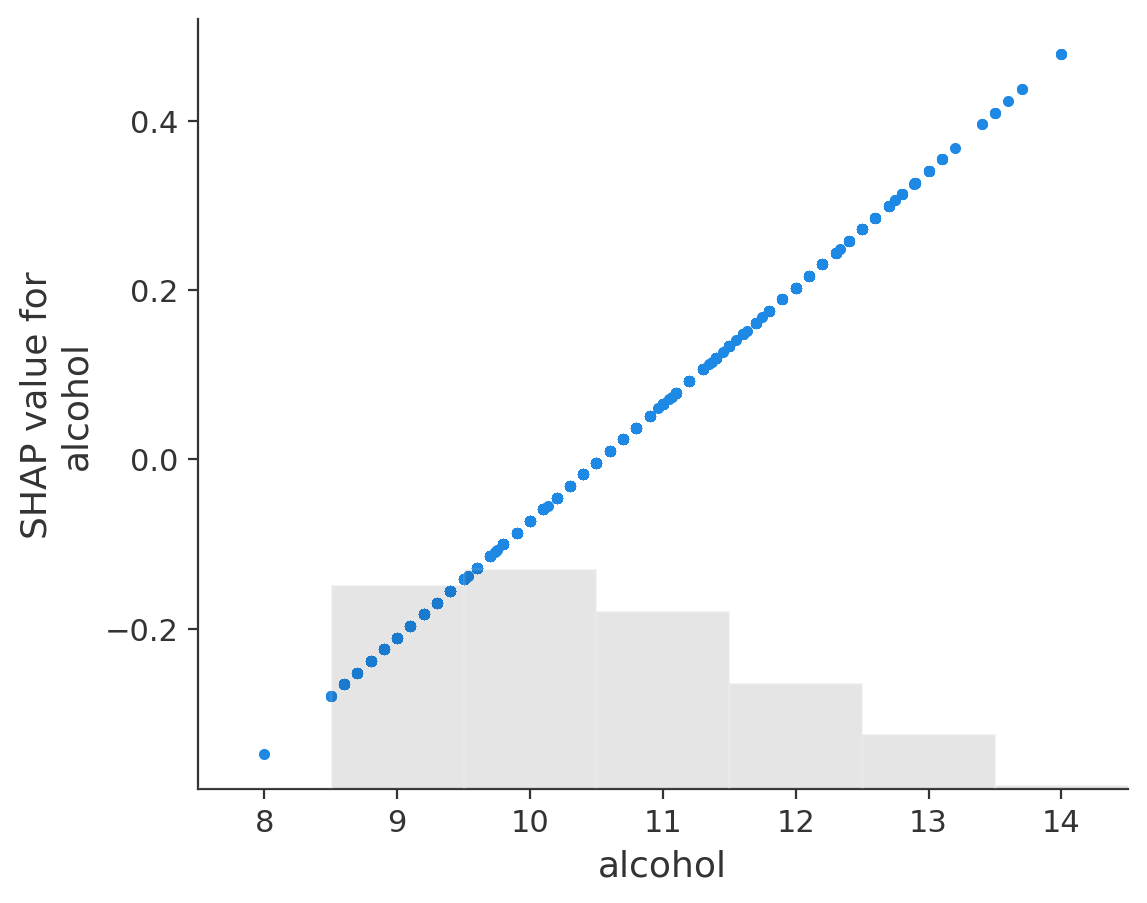

In [ ]:
shap.plots.scatter(shap_values[:, 'alcohol'])

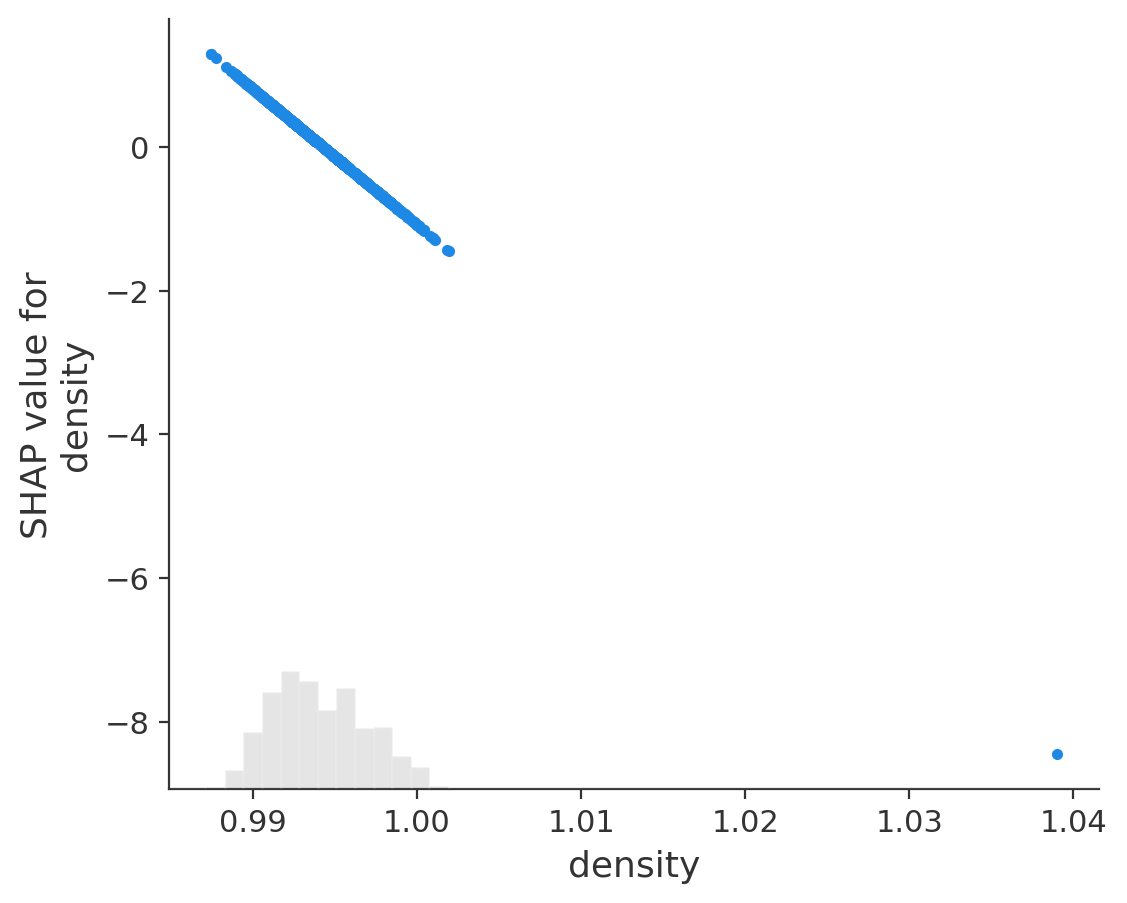

In [ ]:
shap.plots.scatter(shap_values[:, 'density'])

### A Random Forest Regressor Now

#### Fitting and Cross-Validating

In [ ]:
model = RandomForestRegressor(
    max_depth=8, min_samples_split=30, min_samples_leaf=30, n_estimators=400
)
model = model.fit(X_train, y_train)

In [ ]:
eval_results = cross_validate(
    model, X, y, cv=5,
    scoring='neg_mean_absolute_error',
    return_train_score=True
)
print(-eval_results['test_score'].mean(), eval_results['test_score'].std())
print(-eval_results['train_score'].mean(), eval_results['train_score'].std())

0.5791446439874743 0.034966292894682546
0.5013388398252104 0.010494175053674339


#### Inspecting with SHAP

In [ ]:
explainer = shap.TreeExplainer(model, X_train)
explainer

In [ ]:
shap_values = explainer(X_test)

 97%|=================== | 950/980 [00:32<00:01]       

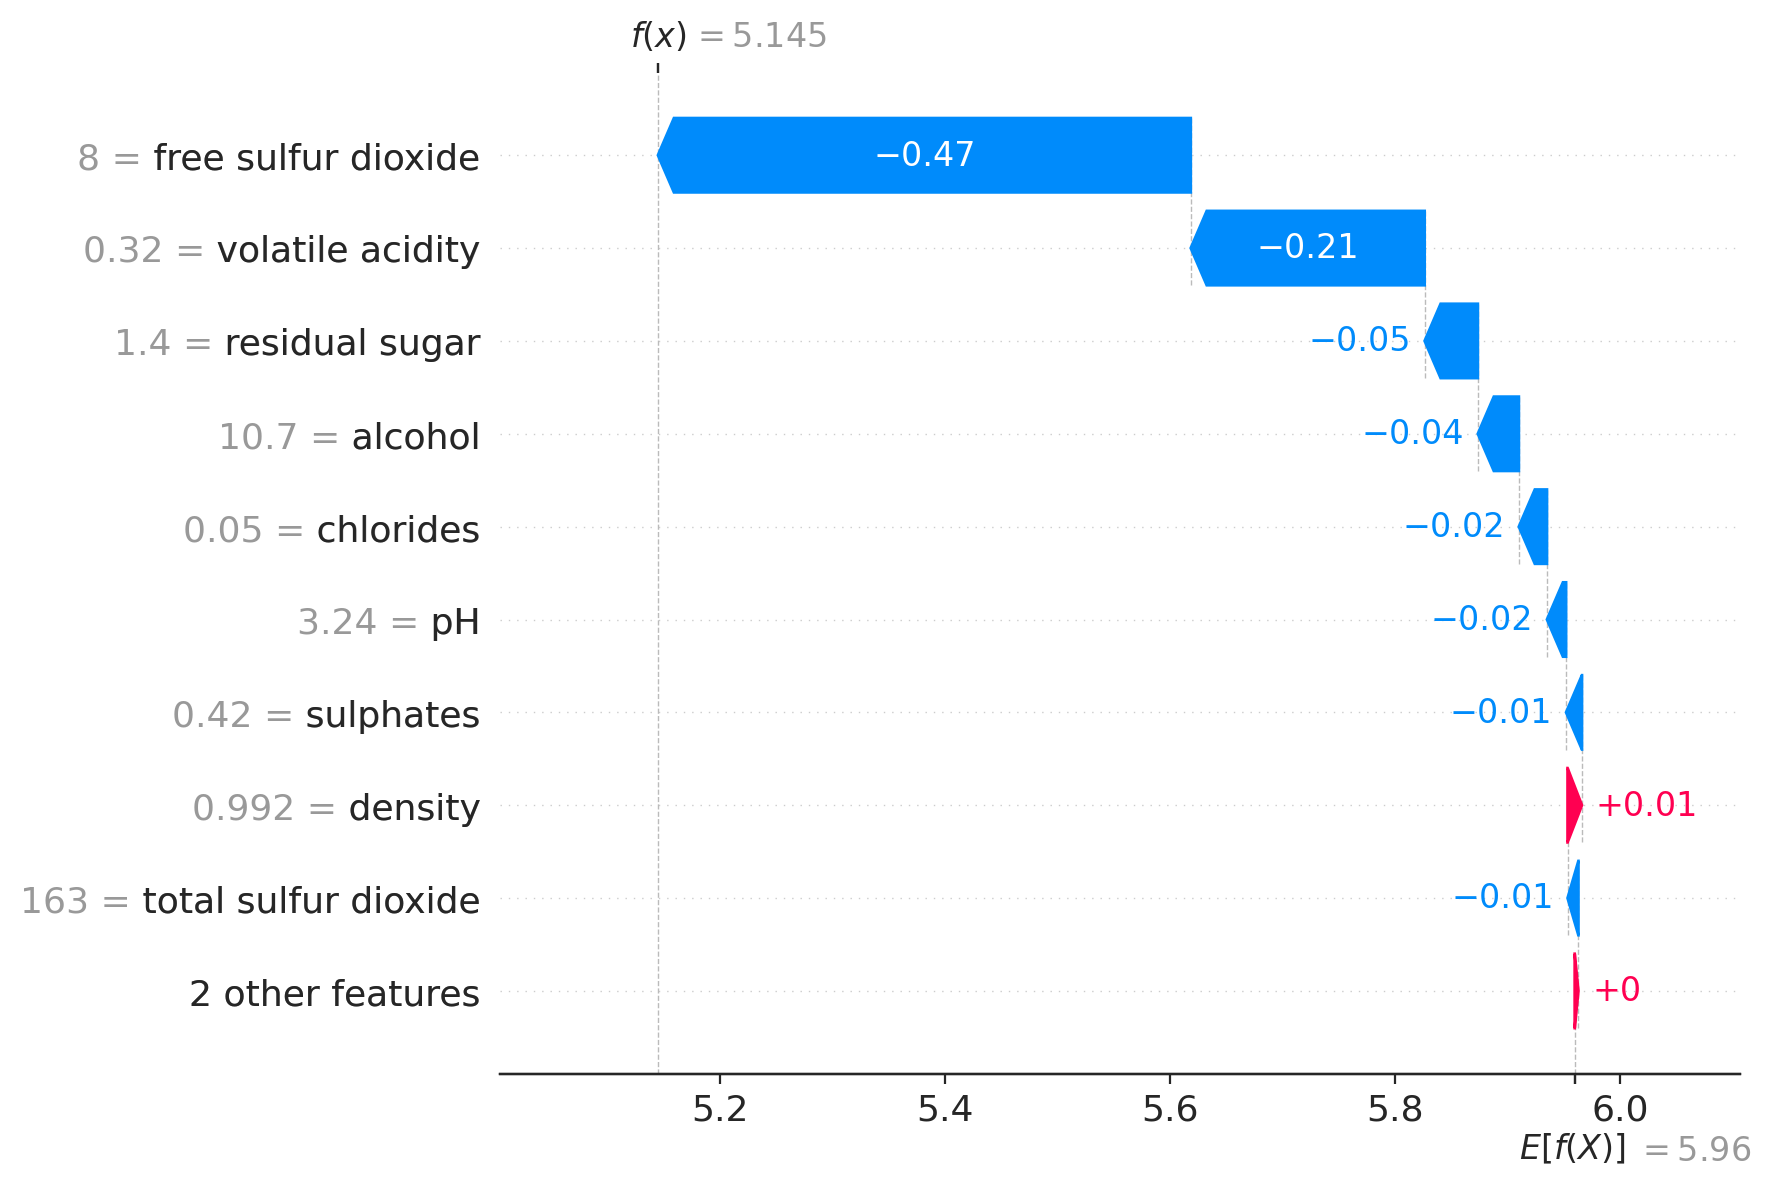

In [ ]:
# for a random instance
shap.plots.waterfall(shap_values[0])

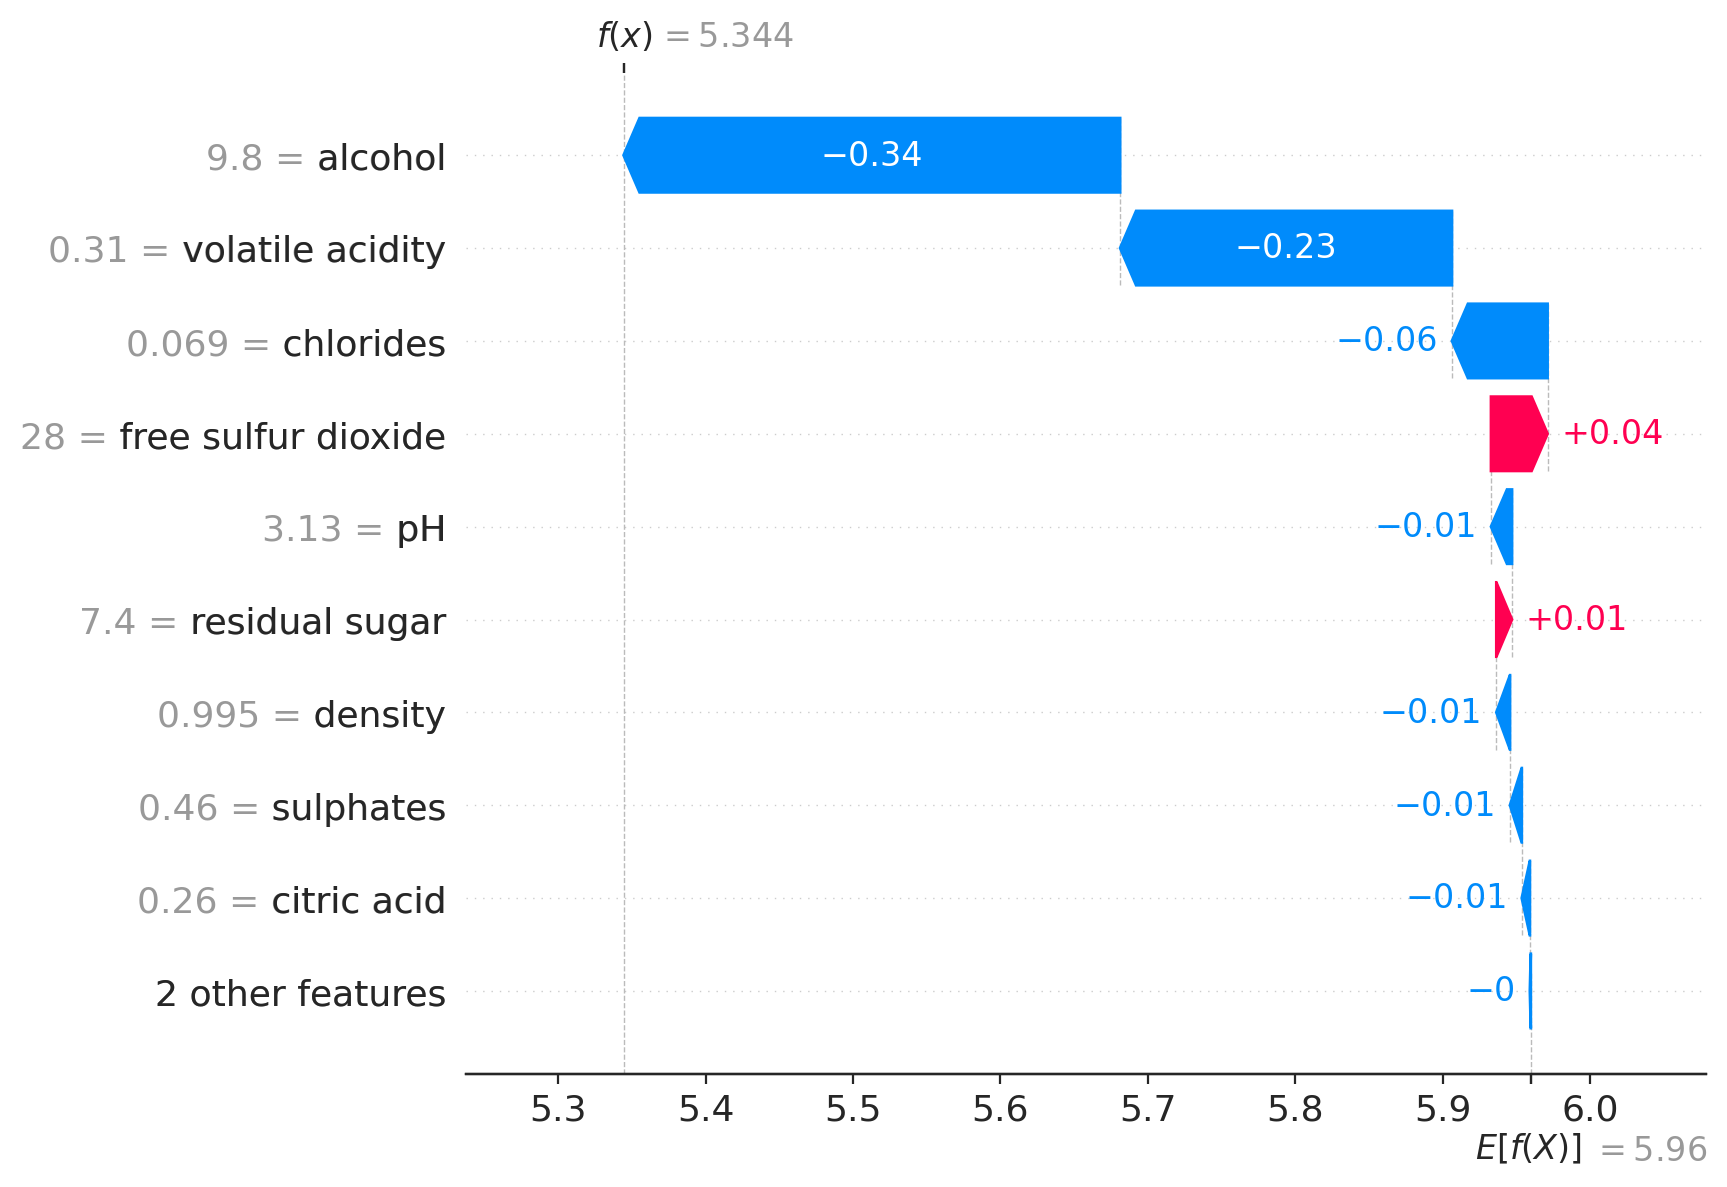

In [ ]:
# another wine
shap.waterfall_plot(shap_values[1])

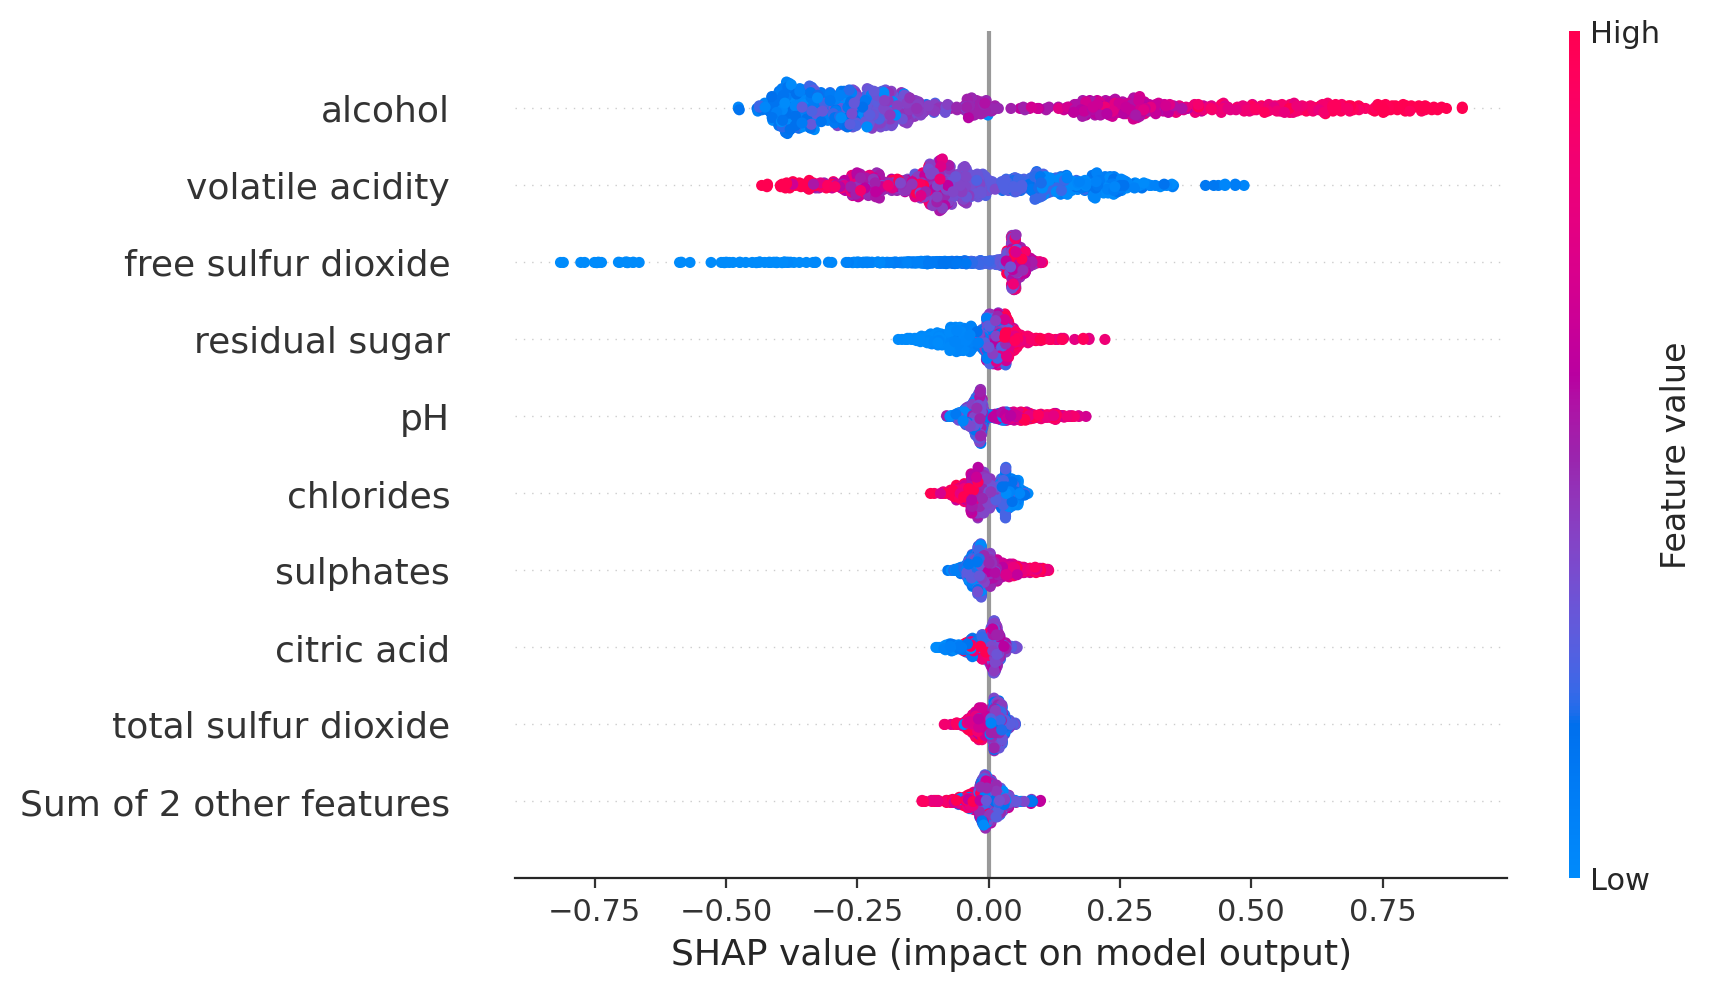

In [ ]:
# global model
shap.plots.beeswarm(shap_values)

#### SHAP Scatter Plots

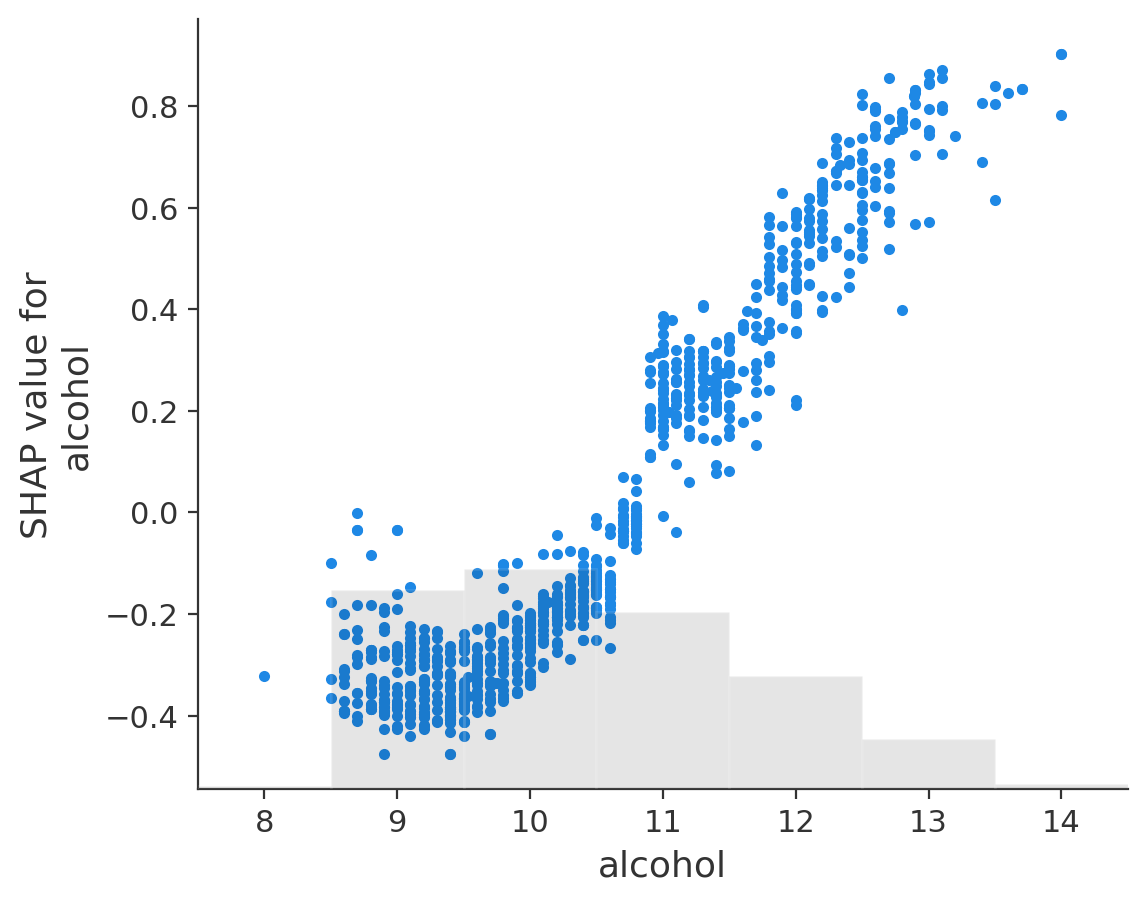

In [ ]:
shap.plots.scatter(shap_values[:, 'alcohol'])

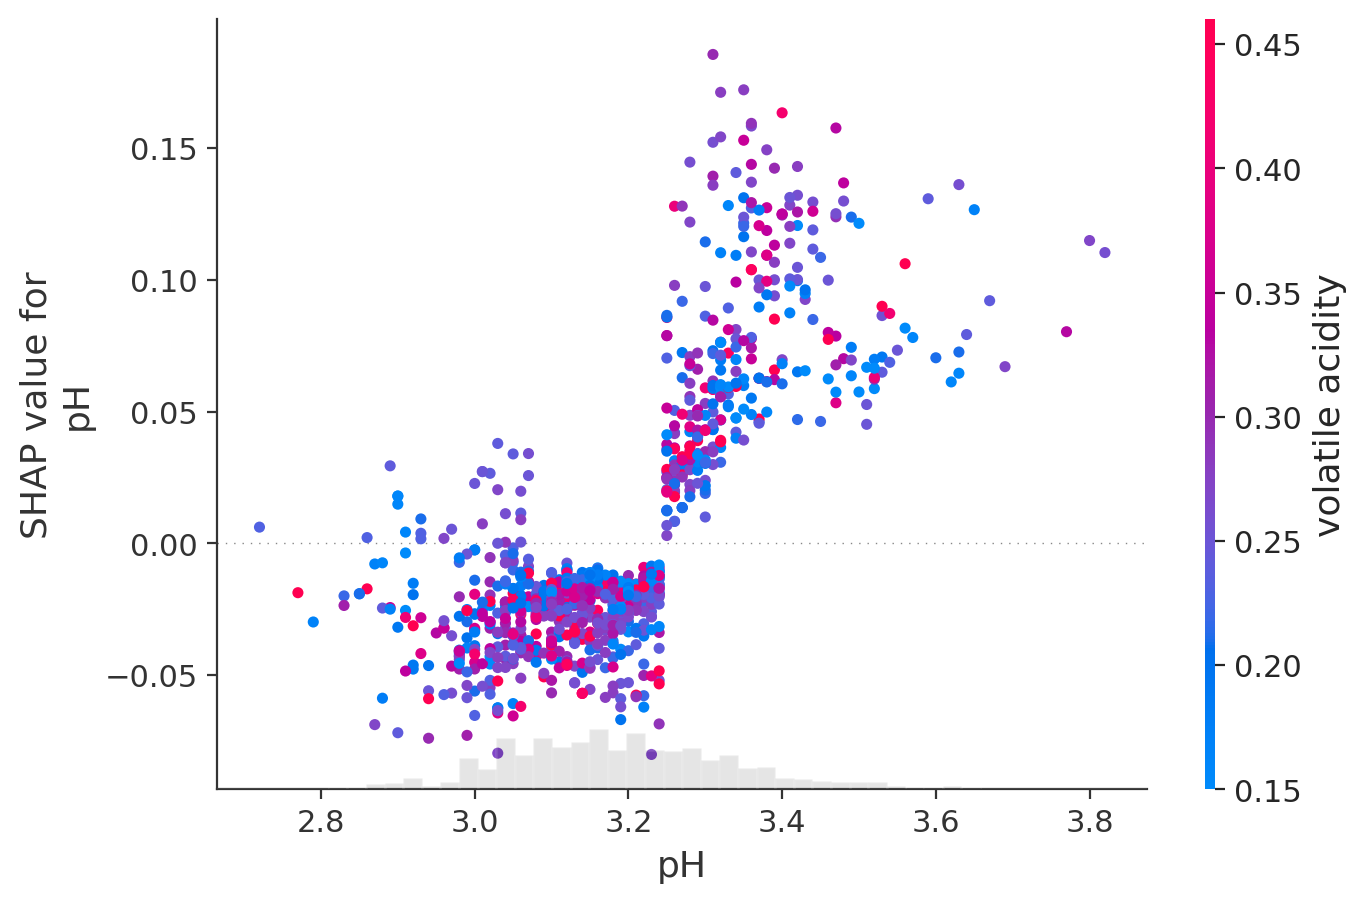

In [ ]:
shap.plots.scatter(shap_values[:,"pH"], color=shap_values[:,"volatile acidity"])

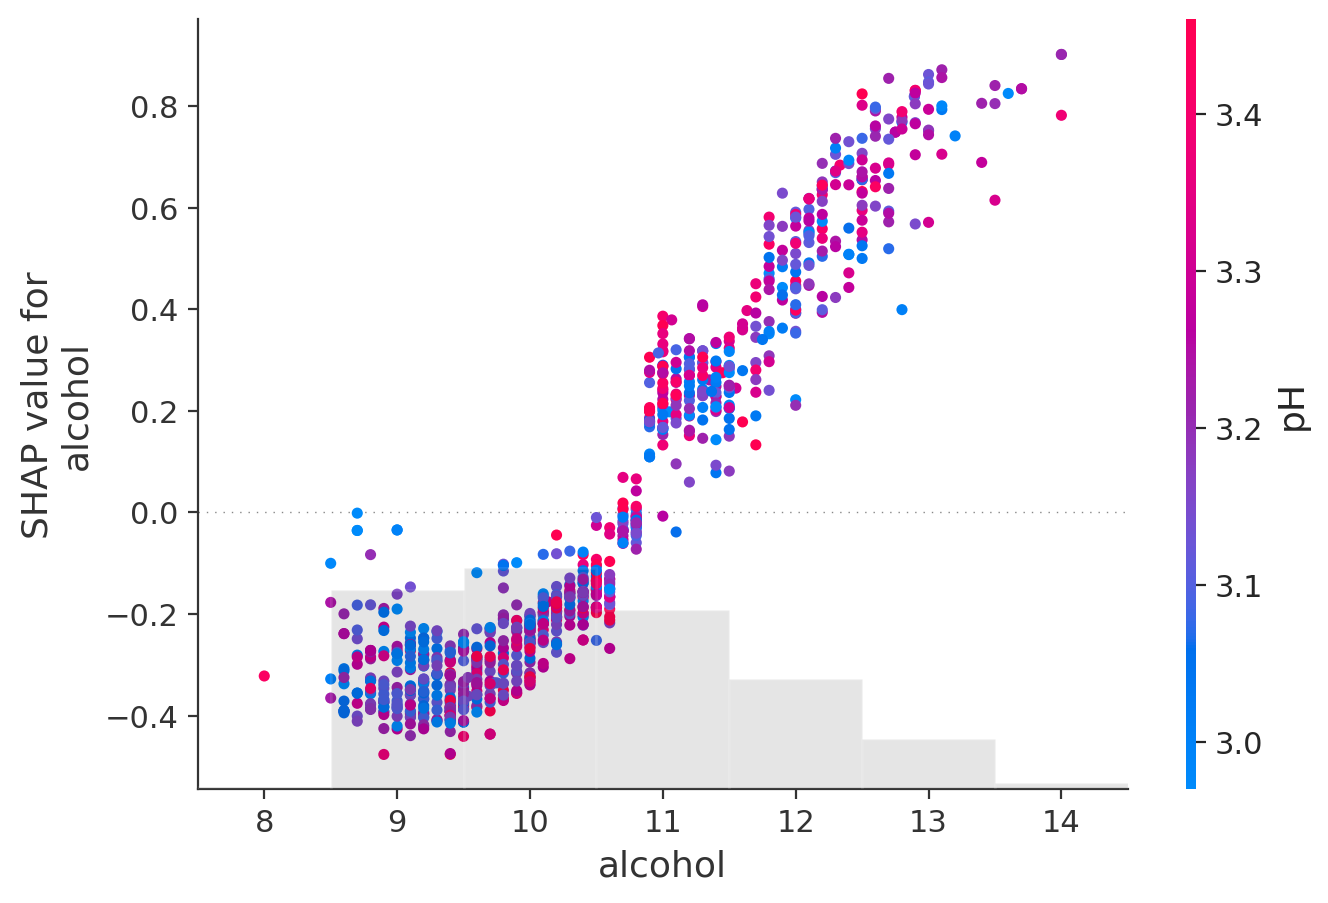

In [ ]:
shap.plots.scatter(shap_values[:,"alcohol"], color=shap_values[:,"pH"])

* "Generally, a higher alcohol level corresponds to a higher SHAP value.

* "Examining cases with low volatile acidity reveals an interesting interaction with wines that have a low alcohol level.
    - For wines with low alcohol (between 8% and 11%), if the wines have low volatile acidity, then the SHAP value for alcohol is higher compared to wines with similar alcohol levels.

    - The relationship reverses for wines with higher alcohol levels: a higher volatile acidity level is associated with slightly higher SHAP values for alcohol."

* "We could infer that volatile acidity alters the effect of alcohol on the predicted wine quality."